In [1]:

import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0,1,2,3" # "0"

In [2]:
import torch
import numpy as np
import h5py
import cv2
import PIL
import os, sys, gc
import argparse
from glob import glob
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img_no_crop
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import watershed,watershed_per_img,watershed_original
from core.median_filter import apply_median_filter_cpu, apply_median_filter_gpu, apply_median_filter_gpu_simple
from core.dataloader_230414 import average_img 
%load_ext autoreload
%autoreload 2



In [3]:
def save_eps(img,path):
    if type(img) == torch.Tensor:
        img = img.cpu().numpy()
    img = (img-img.min())/(img.max()-img.min())
    img = PIL.Image.fromarray((img*255).astype('uint8'))
    img.save(path,dpi=(300,300),mode='EPS')

In [4]:
folder_name = "./N2N_output_230917_wholeimg_on230414"
os.makedirs(folder_name, exist_ok=True)


In [5]:
path_list = ["/home/hyunwoong/FBI-Denoiser/data/Samsung_SNU_dataset_230414_1710x2990_aligned"
                 ]


In [6]:
def get_scene_number(filename):
    return str(int(filename.split("_")[1].split('-')[0]))
from glob import glob
def load_img_dict(target_x,target_y,debug=True):
    
    path_list = ["/home/hyunwoong/FBI-Denoiser/data/Samsung_SNU_dataset_230414_1710x2990_aligned"
                 ]
    # data_path = "/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_aligned_ordered/" 

    unique_scene = np.unique(list(map(get_scene_number,os.listdir(path_list[0]))))
    print(unique_scene)
    # array of [01 ~ 42]
    f_num_list = ['F01','F32']
    img_dict = {}
    # for f_num in f_num_list:
    #     img_dict[f_num] = {}
    #     for scene_num in unique_scene:
    #         # print(f_num,scene_num)
    #         img_dict[f_num][scene_num] = []
    img_dict = {}
    for data_path in path_list:
        print("=====",data_path, "=====")
        for f_num in f_num_list:
            img_dict[f_num] = {}
            f_number = int(f_num[1:])
            f_num = f"F{f_number:02d}"
            
            # img_list = sorted(os.listdir(data_path))
            img_list = sorted(glob(os.path.join(data_path,f"{f_num}_*")))
            img_list = list(filter(lambda x : ".ipynb_checkpoints" not in x,img_list))
            
            for filename in sorted(img_list):
                filename = filename.split("/")[-1]
                img_path = os.path.join(data_path,filename)
                image_idx = int(filename.split("-")[1].split(".")[0])
                scene_num = get_scene_number(filename)
                if scene_num not in img_dict[f_num].keys():
                    img_dict[f_num][scene_num] = []
                filename = f"{f_num}_{scene_num}-{image_idx:02d}.png"
                img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE) 
                # img_dict[set_num][f_num].append(img)
                # img = np.expand_dims(img,axis=0)
                img = np.expand_dims(img,axis=0) / 255.
                img_dict[f_num][scene_num].append(img)
                if debug is True:
                    print(img_path)
                    print(f_num,scene_num,img.shape)
                    print(len(img_dict[f_num][scene_num]))
                    break
    if debug is True:
        print(img_dict.keys())
        for f_num in img_dict.keys():
            for scene_num in img_dict[f_num].keys():
                print(f_num,scene_num,len(img_dict[f_num][scene_num]))
                print("   ",img_dict[f_num][scene_num][0].shape)
            
    print("====== load img_dict complete ======")
    return img_dict
                        

In [7]:
img_dict = load_img_dict('F01','F32',debug=False)

['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '22'
 '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35' '36'
 '37' '38' '39' '4' '40' '41' '42' '5' '6' '7' '8' '9']
===== /home/hyunwoong/FBI-Denoiser/data/Samsung_SNU_dataset_230414_1710x2990_aligned =====
====== load img_dict complete ======


In [8]:
print(img_dict.keys())
for f_num in img_dict.keys():
    for scene_num in img_dict[f_num].keys():
        print(f_num,scene_num,len(img_dict[f_num][scene_num]))
        print("   ",np.array(img_dict[f_num][scene_num]).shape)

dict_keys(['F01', 'F32'])
F01 1 16
    (16, 1, 1710, 2990)
F01 2 16
    (16, 1, 1710, 2990)
F01 3 16
    (16, 1, 1710, 2990)
F01 4 16
    (16, 1, 1710, 2990)
F01 5 16
    (16, 1, 1710, 2990)
F01 6 16
    (16, 1, 1710, 2990)
F01 7 16
    (16, 1, 1710, 2990)
F01 8 16
    (16, 1, 1710, 2990)
F01 9 16
    (16, 1, 1710, 2990)
F01 10 16
    (16, 1, 1710, 2990)
F01 11 16
    (16, 1, 1710, 2990)
F01 12 16
    (16, 1, 1710, 2990)
F01 13 16
    (16, 1, 1710, 2990)
F01 14 16
    (16, 1, 1710, 2990)
F01 15 16
    (16, 1, 1710, 2990)
F01 16 16
    (16, 1, 1710, 2990)
F01 17 16
    (16, 1, 1710, 2990)
F01 18 16
    (16, 1, 1710, 2990)
F01 19 16
    (16, 1, 1710, 2990)
F01 20 16
    (16, 1, 1710, 2990)
F01 21 16
    (16, 1, 1710, 2990)
F01 22 16
    (16, 1, 1710, 2990)
F01 23 16
    (16, 1, 1710, 2990)
F01 24 16
    (16, 1, 1710, 2990)
F01 25 16
    (16, 1, 1710, 2990)
F01 26 16
    (16, 1, 1710, 2990)
F01 27 16
    (16, 1, 1710, 2990)
F01 28 16
    (16, 1, 1710, 2990)
F01 29 16
    (16, 1, 1710, 299

(1280, 2816)


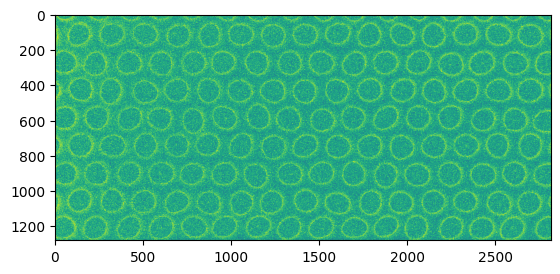

In [9]:

top_crop = 290
bottom_crop = 140
left_crop = 174
print(img_dict['F01']['1'][0][0][top_crop:-bottom_crop,:-left_crop].shape)
plt.imshow(img_dict['F01']['1'][0][0][top_crop:-bottom_crop,:-left_crop])

In [10]:

import itertools
def get_fbi_weight(f_num_list = ['F#','F01','F02','F04','F08','F16','F32','F64'],loss = 'MSE_Affine',filter_keyword = ['median']):
    comb = list(itertools.combinations(f_num_list,2))
    total_fbi_weight_list = {}
    for x_f_num,y_f_num in comb:
        fbi_weight_list = glob(f"../weights/230*_FBI_Net*x_as_{x_f_num}*y_as_{y_f_num}*{loss}*")
        for keyword in filter_keyword:
            fbi_weight_list = list(filter(lambda x : keyword not in x,fbi_weight_list))
        total_fbi_weight_list += sorted(list(fbi_weight_list))
        print(x_f_num,y_f_num)
        for fbi_weight in fbi_weight_list:
            print(fbi_weight)
    return total_fbi_weight_list

In [11]:
!ls ../weights/230*NAFNet*N2N*MSE_Affine.w

../weights/230914_NAFNet_light_MSE_Affine_Grayscale_N2N_F01-F01_Samsung_MSE_Affine.w
../weights/230914_NAFNet_light_MSE_Affine_Grayscale_N2N_F01-F02_Samsung_MSE_Affine.w
../weights/230914_NAFNet_light_MSE_Affine_Grayscale_N2N_F01-F04_Samsung_MSE_Affine.w
../weights/230914_NAFNet_light_MSE_Affine_Grayscale_N2N_F01-F08_Samsung_MSE_Affine.w


In [12]:
gc.collect()
debug= False
partial_check = True
target_fbi_weight = [
    # "../weights/230914_FBI_Net_EMSE_Affine_Grayscale_N2N_F01-F01_Samsung_EMSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    
    # "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F01_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F02_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F04_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F08_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # # "../weights/230920_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F32_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256_epoch15.w",
    # "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F32_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230920_FBI_Net_MSE_Grayscale_N2N_F01-F32_Samsung_MSE_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230914_FBI_Net_N2V_Grayscale_N2N_F01-F01_Samsung_N2V_layers_x17_filters_x64_cropsize_256.w",
    
    # "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F02-F02_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F02-F04_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F04-F04_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",

    # "../weights/230901_FBI_Net_Grayscale_N2N_F04-F08_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230901_FBI_Net_Grayscale_N2N_F08-F08_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230914_NAFNet_light_MSE_Affine_Grayscale_N2N_F01-F01_Samsung_MSE_Affine.w",
    "../weights/230914_NAFNet_light_MSE_Affine_Grayscale_N2N_F01-F02_Samsung_MSE_Affine.w",
    "../weights/230914_NAFNet_light_MSE_Affine_Grayscale_N2N_F01-F04_Samsung_MSE_Affine.w",
    "../weights/230914_NAFNet_light_MSE_Affine_Grayscale_N2N_F01-F08_Samsung_MSE_Affine.w",
    
]


In [13]:


def parsing_weight_name(fbi_weight_dir):
    target_f = fbi_weight_dir.split("N2N_")[1].split("_Samsung")[0]
    target_x,target_y = target_f.split("-")
    info = "_".join(fbi_weight_dir.split("_")[1:]).split("_Grayscale")[0]
    arch = "_".join(info.split("_")[:2])
    if arch == 'FBI_Net':
        loss_func =  "".join(fbi_weight_dir.split("Samsung_")[1].split("_layers")[0])
    else :
        loss_func = "".join(fbi_weight_dir.split("Samsung_")[1].split(".w")[0])
    try: 
        add_info = fbi_weight_dir.split("cropsize_256_")[1].split(".w")[0]
    except :
        add_info = ""
    return target_x,target_y, arch, loss_func, add_info


In [14]:

args = get_args(env='colab')
args.pge_weight_dir = None #pge_weight_dir
args.loss_function = "MSE_Affine"
args.noise_type = 'Poisson-Gaussian'
args.model_type = 'NAFNet_light'#'FBI_Net'
# args.set_num = '1'
args.data_name = 'Samsung'
args.data_type = 'Grayscale'
args.lr = 0.001
args.num_layers = 17
args.num_filters = 64
# args.crop_size = 200
args.debug = False

In [15]:
for weight in target_fbi_weight:
    print(parsing_weight_name(weight))

('F01', 'F01', 'NAFNet_light', 'MSE_Affine', '')
('F01', 'F02', 'NAFNet_light', 'MSE_Affine', '')
('F01', 'F04', 'NAFNet_light', 'MSE_Affine', '')
('F01', 'F08', 'NAFNet_light', 'MSE_Affine', '')


In [16]:
metric = {}

In [17]:
from re import T
from core.utils import get_PSNR,get_SSIM

debug = False
imshow = False
for weight_idx,fbi_weight_dir in enumerate(target_fbi_weight):

    target_x,target_y, arch, loss_func,add_info = parsing_weight_name(fbi_weight_dir)
    # if target_y != 'F08' :
    #     continue
    if debug is True:
        print(fbi_weight_dir)
        # print(median_filter_input,"median_filter_input")
    # key = f"{target_x}-{target_y}_{dataset_version}"
    key = f"{target_x}-{target_y}_{arch}"
    if loss_func != 'MSE_Affine':
        key += f"_{loss_func}"
    if add_info != "":
        key += f"_{add_info}"
    model_img_path = f"{folder_name}/{key}"
    os.makedirs(model_img_path,exist_ok=True)
    args.loss_function = loss_func
    args.model_type = arch
    if args.loss_function == 'EMSE_Affine':
        args.pge_weight_dir = "../weights/230914_PGE_Net_Noise_est_Grayscale_N2N_F01-F01_Samsung_Noise_est_cropsize_256_vst_MSE.w"
    else :
        args.pge_weight_dir = None
    print(f"========= {key}  & {loss_func }=========")
    
    model = produce_denoised_img_no_crop(_pge_weight_dir=None,_fbi_weight_dir = fbi_weight_dir,_args = args)
    
    # DENOISE IMAGE
    # target_x = ['F01']
    
    f_number = int(target_x[1:])
        
    if weight_idx == 0:
        metric['median_filter'] = {
            'PSNR' : [],
            'SSIM' : []
        }
        metric['raw'] = {
                'PSNR' : [],
                'SSIM' : []
            }
        # metric['bm3d'] = {
        #     'PSNR' : [],
        #     'SSIM' : []
        # }
    metric[key] = {
            'PSNR' : [],
            'SSIM' : []
        }
    for f_num in [target_x]:
        print(f_num)
        for scene_num in img_dict['F01'].keys():
        
            # print(f"Since F#, f_num : {f_num} Start")
            print(f"Denoising f_num : {f_num} scene num : {scene_num} Start")
            
            # for idx,img in enumerate(img_dict[f_num][scene_num]):
            for idx in range(0,len(img_dict['F01'][scene_num]),f_number):
                print(f"F0{f_number} : convert multiple img to one img")
                img = np.concatenate(img_dict['F01'][scene_num][idx:idx+f_number],axis=0)
                img = average_img(img)
                img = np.expand_dims(img,axis=0)
                if debug is True:
                    print(img.shape)
                img = img[:,top_crop:-bottom_crop,:-left_crop]
                img = np.expand_dims(img, axis=0) # 1,1, 1710, 2990)
                clean_img = img_dict['F32'][scene_num][0]
                clean_img = clean_img[:,top_crop:-bottom_crop,:-left_crop][0]
                print(get_PSNR(clean_img,img[0][0]))
                print(f_num,scene_num,idx,img.shape)
                denoised_img = model.eval(img)[0][0]
                img = img[0][0]
                metric[key]['PSNR'].append(get_PSNR(clean_img,denoised_img))
                metric[key]['SSIM'].append(get_SSIM(clean_img,denoised_img))
                filename = f"{f_num}_{scene_num}-{idx:02d}.png"
                if os.path.exists(f"{model_img_path}/{filename}") is False:
                    print("imwrite : ",f"{model_img_path}/{filename}")
                    if type(denoised_img) == torch.Tensor:
                        denoised_img = denoised_img.cpu().detach().numpy()
                    cv2.imwrite(f"{model_img_path}/{filename}",denoised_img*255)
                if imshow is True and idx ==0 and scene_num == 0:
                    plt.figure(figsize=(20,20))
                    plt.title(f"{f_num}_{scene_num}-{idx:02d}.png\n{key}")
                    if type(denoised_img) == torch.Tensor:
                        denoised_img = denoised_img.cpu().detach().numpy()
                    plt.subplot(211)
                    plt.imshow(denoised_img)
                    plt.subplot(212)
                    plt.imshow(clean_img)
                    plt.pause(0.01)
                if weight_idx == 0:
                    metric['raw']['PSNR'].append(get_PSNR(clean_img,img))
                    metric['raw']['SSIM'].append(get_SSIM(clean_img,img))
                
                    medianfilterd_img = apply_median_filter_gpu_simple(img)[0][0]
                    median_psnr, median_ssim =  get_PSNR(clean_img,medianfilterd_img), get_SSIM(clean_img,medianfilterd_img)
                    metric['median_filter']['PSNR'].append(median_psnr)
                    metric['median_filter']['SSIM'].append(median_ssim)
                    
                    if scene_num == '1' and idx == 0:
                        filename = f"{folder_name}/F32.eps"
                        if os.path.exists(filename) is False:
                            save_eps(clean_img,filename)
                        filename = f"{folder_name}/median_filter_f32.eps"
                        if os.path.exists(filename) is False:
                            save_eps(medianfilterd_img,filename)
                if debug is True:
                    break
        if debug is True:
            break
        print(f"Denoising f_num : {f_num} scene_num : {scene_num} End")
    if debug is True:
        break
    del model
    gc.collect()


========= F01-F01_NAFNet_light  & MSE_Affine=========
F01
Denoising f_num : F01 scene num : 1 Start
F01 : convert multiple img to one img
11.093202106512845
F01 1 0 (1, 1, 1280, 2816)
imwrite :  ./N2N_output_230917_wholeimg_on230414/F01-F01_NAFNet_light/F01_1-00.png
F01 : convert multiple img to one img
11.184794000938004
F01 1 1 (1, 1, 1280, 2816)
imwrite :  ./N2N_output_230917_wholeimg_on230414/F01-F01_NAFNet_light/F01_1-01.png
F01 : convert multiple img to one img
11.185597506582383
F01 1 2 (1, 1, 1280, 2816)
imwrite :  ./N2N_output_230917_wholeimg_on230414/F01-F01_NAFNet_light/F01_1-02.png
F01 : convert multiple img to one img
11.20759141076999
F01 1 3 (1, 1, 1280, 2816)
imwrite :  ./N2N_output_230917_wholeimg_on230414/F01-F01_NAFNet_light/F01_1-03.png
F01 : convert multiple img to one img
11.211839805966717
F01 1 4 (1, 1, 1280, 2816)
imwrite :  ./N2N_output_230917_wholeimg_on230414/F01-F01_NAFNet_light/F01_1-04.png
F01 : convert multiple img to one img
11.205540481922098
F01 1 5 (

In [18]:
refined_metric = {}
for key in metric.keys():
    print(key)
    refined_metric[key] = {}
    for sub_key in metric[key].keys():     
        print(key,sub_key)
        if type(metric[key][sub_key]) == dict:
            metric[key][sub_key] = list(metric[key][sub_key].values())
        refined_metric[key][f'{sub_key}'] = np.mean(metric[key][sub_key])
        

import pandas as pd
refined_metric = pd.DataFrame(refined_metric)
refined_metric

median_filter
median_filter PSNR
median_filter SSIM
raw
raw PSNR
raw SSIM
F01-F01_NAFNet_light
F01-F01_NAFNet_light PSNR
F01-F01_NAFNet_light SSIM
F01-F02_NAFNet_light
F01-F02_NAFNet_light PSNR
F01-F02_NAFNet_light SSIM
F01-F04_NAFNet_light
F01-F04_NAFNet_light PSNR
F01-F04_NAFNet_light SSIM
F01-F08_NAFNet_light
F01-F08_NAFNet_light PSNR
F01-F08_NAFNet_light SSIM


,median_filter,raw,F01-F01_NAFNet_light,F01-F02_NAFNet_light,F01-F04_NAFNet_light,F01-F08_NAFNet_light
PSNR,19.249373,12.099397,19.483287,19.563888,19.429896,19.493437
SSIM,0.201017,0.033967,0.219713,0.221895,0.221316,0.220324


![Alt text](image-1.png)

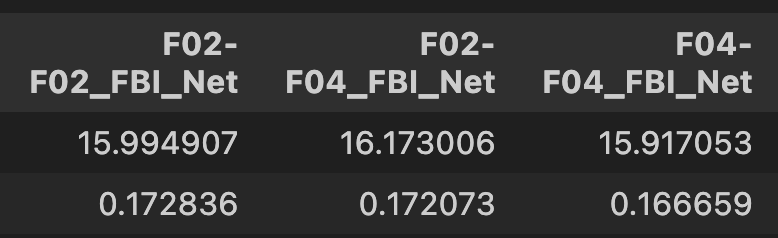

In [19]:
refined_metric.to_csv(f"{folder_name}/metric_whole_230414_on_SEM2_GPU0_NAFNet.csv")
refined_metric.T.to_csv(f"{folder_name}/metric_whole_230414_on_SEM2_GPU0_T_NAFNet.csv")

In [20]:
from knockknock import telegram_sender
@telegram_sender(token='1531143270:AAFTord-4Bi370ohc39wGyYhjGi7_VjZTwU', chat_id=1597147353)
def denoising_end():
    print("Denoising End")
denoising_end()
!date

Denoising End
Sun Oct  1 13:06:56 UTC 2023
